<a href="https://colab.research.google.com/github/ggug0125-ui/AI_26/blob/main/05_01_%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MBC 마켓에서 신상품으로 캔 와인을 판매하려고 한다.
# 주류는 온라인 판매가 안되서 온라인 예약 후에
# 오프라인매장에서 구매를 유도하려고 함

# 입고된 와인을 보니 레드와인인지 화이트와인인지 구분표시가 안되었음
# 캔에 인쇄된 알콜도수, 당도, pH 값으로 와인 종류를 구별해보자.

# 품질확인용으로 뜯은 캔이 테스트용으로 있고 이것을 데이터로 활용
# 로지스틱 회귀 모델로 적용을 해서 알아보자.

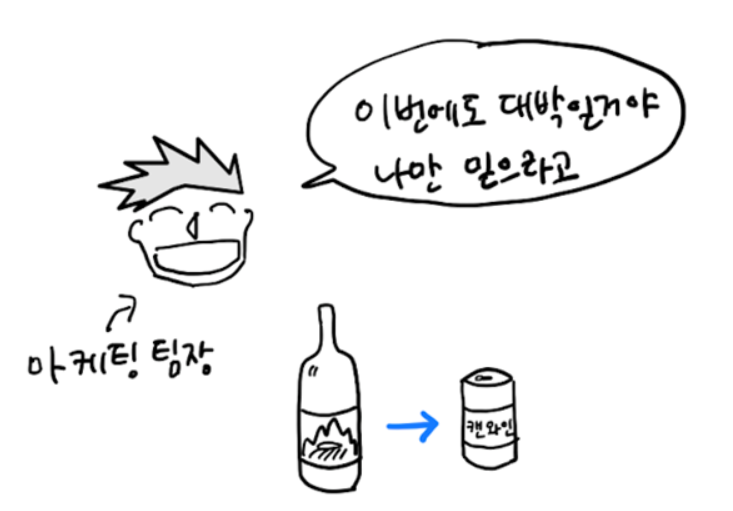

In [6]:
# 와인의 특성화된 데이터 넣자
import pandas as pd
wine = pd.read_csv('https://bit.ly/wine_csv_data')
wine.head()
# 알콜, 당도, 산도, 클래스(타킷 =0(레드와인), 1(화이트와인))
# 데이터에서 화이트와인이 양성클래스로 화이트와인을 표시하는 문제

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [7]:
wine. info()
# 결과 6497개의 샘플 4개의 열(실수형)
# Non-Null 누락된 값이 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [9]:
wine.describe()# 열에 대한 통계
# mean=평균, std=표준편차, min=최소,
# 25%=1사분위수, 50%=중간값(2 사분위), 75%=3사분위, max=(100%, 4사분위)
# 사분위수 : 데이터를 순서대로 4등분한 값

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [10]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
# wine 데이터에서 alcohol, sugar, pH 세 개의 컬럼만 선택
# 머신러닝 입력(feature, X)으로 사용할 값들
# to_numpy() → pandas DataFrame을 numpy 배열로 변환
# sklearn 모델은 내부적으로 numpy 배열을 사용하기 때문에 변환해주는 과정

target = wine['class'].to_numpy()
# 정답(label, y)을 따로 분리
# class 컬럼은 와인 종류
# 0 = 레드 와인
# 1 = 화이트 와인 (양성 클래스)

print(data)
# 입력 데이터(X)를 실제 배열 형태로 출력해서 확인
# 각 행(row) = 와인 한 병
# 각 열(column) = alcohol, sugar, pH 값


[[ 9.4   1.9   3.51]
 [ 9.8   2.6   3.2 ]
 [ 9.8   2.3   3.26]
 ...
 [ 9.4   1.2   2.99]
 [12.8   1.1   3.34]
 [11.8   0.8   3.26]]


In [11]:
print(target) # 훈련정답

[0. 0. 0. ... 1. 1. 1.]


In [13]:
# 훈련세트와 테스트 세트로 나눔
from sklearn.model_selection import train_test_split
# 데이터를 훈련용(train)과 테스트용(test)으로 나누는 함수 불러오기

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)
# 전체 데이터를 무작위로 섞은 뒤(train_test_split 기본 동작)
# 80%는 훈련용, 20%는 테스트용으로 분리

# data → 입력(X)
# target → 정답(y)

# train_input   : 모델이 공부할 입력 데이터
# test_input    : 모델 시험용 입력 데이터
# train_target  : 훈련 정답
# test_target   : 테스트 정답

# test_size=0.2 → 전체의 20%를 테스트 데이터로 사용
# random_state=42 → 항상 같은 방식으로 섞이도록 고정(재현성 확보)

print(train_input.shape, test_input.shape) # 6496 * 0.8 = 5196.8

(5197, 3) (1300, 3)


In [14]:
from sklearn.preprocessing import StandardScaler
# 훈련세트 전처리 (표준점수로 변환 : 단위를 맞추는 효과)
ss = StandardScaler()
# StandardScaler 객체 생성
# 아직 계산은 안 하고 준비만 한 상태

ss.fit(train_input) # 훈련시작
# 훈련 데이터의 평균(mean)과 표준편차(std)를 계산
# 실제 변환은 하지 않고 "기준"만 학습하는 단계

train_scaled = ss.transform(train_input)
# 학습된 평균과 표준편차를 이용해서 훈련 데이터를 변환
test_scaled = ss.transform(test_input)
# 테스트 데이터도 같은 기준(mean, std)으로 변환

print(train_scaled)
print('----------------')
print(test_scaled)

[[ 0.01376574  0.4646116  -0.16888369]
 [ 1.60871671 -0.70299854  0.26967864]
 [ 1.10504798 -0.70299854  1.20945505]
 ...
 [-0.82568214  0.0267578   0.14437512]
 [-0.82568214  0.52716215 -0.23153545]
 [-0.82568214 -0.57789745  1.83597265]]
----------------
[[ 1.44082714  1.52797084  0.26967864]
 [-0.48990299 -0.68214836  0.3323304 ]
 [ 1.27293756  0.40206106 -0.23153545]
 ...
 [ 1.60871671 -0.76554908 -0.16888369]
 [-0.90962693  0.88161523  0.52028568]
 [-1.49724045  2.09092573 -1.98578474]]


In [16]:
from sklearn.linear_model import LogisticRegression
# 로지스틱 회귀 모델 불러오기
# 확률(sigmoid)을 이용한 대표적인 이진 분류 모델

lr = LogisticRegression() # 로지스틱 회귀 모델 훈련
lr.fit(train_scaled, train_target) # 훈련시작
# 훈련 데이터로 모델 학습 시작
# 경사하강법 기반 최적 가중치(w,b)를 찾는 과정

print(lr.score(train_scaled, train_target)) # 78.08%
print(lr.score(test_scaled, test_target))   # 77.76%


0.7808350971714451
0.7776923076923077


In [18]:
# 제출용 보고서를 만들어 보자.
print(lr.coef_, lr.intercept_)  # 로지스틱 회귀(계수=가중치, 절편=더해지는값)
# 모델이 학습한 가중치(weight)와 절편(bias)을 출력
# 즉 AI가 만든 실제 수학 공식 확인

[[ 0.51268071  1.67335441 -0.68775646]] [1.81773456]


In [ ]:
# 알콜 도수값이 0.51268071를 곱하고,
# 당도에 1.67335441를 곱하고,
# pH값에 -0.68775646을 곱한 다음 모두 더함
# 위에 나온 값에 절편 1.81773456을 더함
# 이값이 0보다 크면 화이트 와인, 작으면 레드와인
# 현재 77% 정도 정확히 화이트 와인으로 분류 완료!!!!

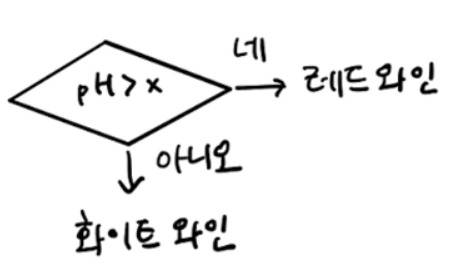

In [19]:
# 결정 트리(이유를 설명하기 쉽다.)
# if문을 사용하는 것과 유사
from sklearn.tree import DecisionTreeClassifier #(Decision:결정_디시전)

# DecisionTreeClassifier 결정 트리 모델로 훈련
dt = DecisionTreeClassifier(random_state=42)
# 결정 트리 분류 모델 생성
# random_state=42 → 트리 생성 과정의 랜덤성을 고정해서 항상 같은 결과 나오게 함

dt.fit(train_scaled, train_target) # 훈련시작
# 훈련 데이터를 이용해 결정 트리를 학습
# 데이터 특징을 기준으로 계속 조건(if문)을 만들면서 분할함

print(dt.score(train_scaled, train_target)) # 훈련 세트
# 훈련 데이터에서의 정확도 계산
# 모델이 "공부한 문제"를 얼마나 잘 맞추는지 확인

print(dt.score(test_scaled, test_target))   # 테스트 세트
# 과대 적합됨 (훈련점수 99.69% , 테스트 점수 85.92%)
# 처음 보는 데이터(시험 문제)에서 정확도 계산
# 실제 모델 성능 평가

0.996921300750433
0.8592307692307692


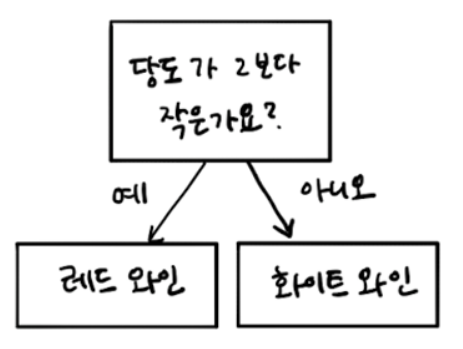

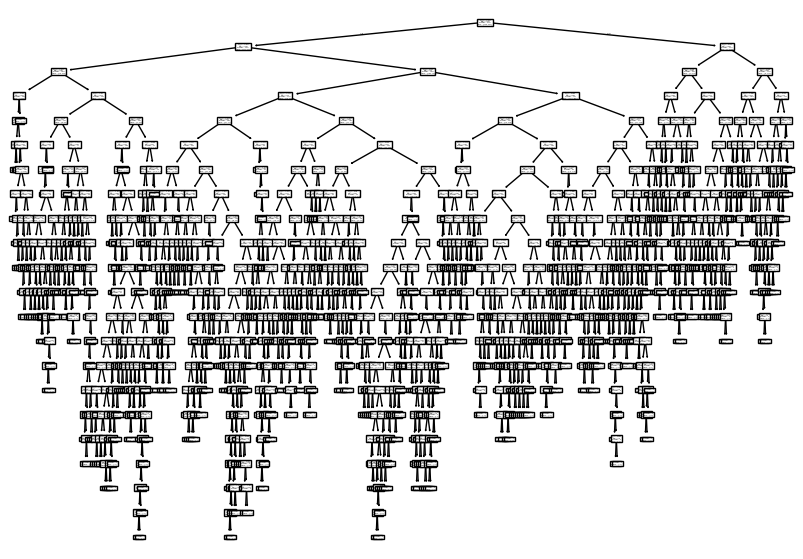

In [21]:
import matplotlib.pyplot as plt
# 그래프를 그리기 위한 matplotlib 라이브러리 불러오기
from sklearn.tree import plot_tree
# 학습된 결정트리 구조를 그림으로 출력하는 함수 불러오기

plt.figure(figsize=(10,7)) # figure(형태,도형)
# figsize=(20,15) 그래프의 사이즈(가로인치, 세로인치)
# 새로운 그래프 영역 생성
# figsize=(가로, 세로) → 그래프 크기 설정 (단위: inch)
# 트리는 노드가 많기 때문에 크게 그리는 것이 보기 좋음

plot_tree(dt)
# 학습된 Decision Tree(dt)의 구조를 시각적으로 출력
# AI가 만든 분기 규칙(if문)을 트리 형태로 보여줌

plt.show()  # 화면에 트리 그래프 출력
#맨위 노드(루트노드),맨아래노드(리프노드)

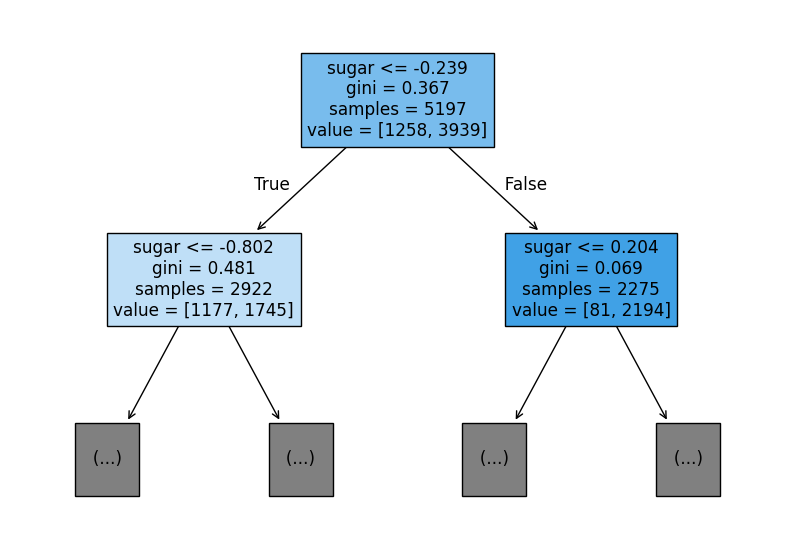

In [23]:
plt.figure(figsize=(10,7))
# 트리를 그릴 새로운 그래프 영역 생성
# figsize=(가로, 세로) → 그래프 크기 설정 (단위 inch)
# 트리 구조가 잘 보이도록 넉넉하게 설정


plot_tree(dt, max_depth=1, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
# max_depth=1
# 트리의 깊이를 1까지만 표시
# 즉:
# 루트 노드 + 바로 아래 1단계 분기까지만 보여줌
# → 가장 중요한 첫 판단 기준만 확인 가능 ⭐

plt.show()

# sugar가 -0.239보다 이상이면 false
# sugar가 -0.239보다 같거나 작으면 true (왼쪽 가지로)
# 총샘플 수는 5,197개, 음성클래스(레드와인) 1,258개, 양성클래스(화이트와인) 3,939개
    # 아래쪽 노드에 왼쪽 노드를 살펴보자
    # 이 노드는 당도가 더 낮은지를 물어보는 노드 (-0.802)
    # 당도가 -0.802와 같거나 낮다면 다시 왼쪽으로
    # 그렇지 않으면 오른쪽으로 이동, 음성클래스 1,177개, 양성클래스 1,745개

    # 오른쪽 노드를 보면 음성클래스가 81개, 양성클래스 2,194개로
    # 대부분이 화이트 와인 샘플이 이 노드로 이동됨

# gini = 0.367 (불순도)
# sample = 5197 (총샘플수)
# value = 값 (1258(1), 3939(0))

In [ ]:
# 노드의 바탕색을 유심히 보면 루트노드보다 더 진하고, 왼쪽 노드는 연해짐
# filled=True로 지정하면 클래스 마다 색깔을 지정함, 비율이 높아지면 점점 진하게 표시함

# 결정트리에서 예측하는 방법은 간단한데, 리프노드에서 가장 많은 클래스가 예측 클래스가 됨
# 만약 이결정 트리로 성장을 멈춘다면 왼쪽 노드에 도달한 샘플과 오른쪽 노드에 도달한
# 샘플은 모두 양성 클래스로 예측된다. (양성 클래스가 많아서)

# gini 불순도로 노드에서 데이터를 분할할 기준을 정하는 값

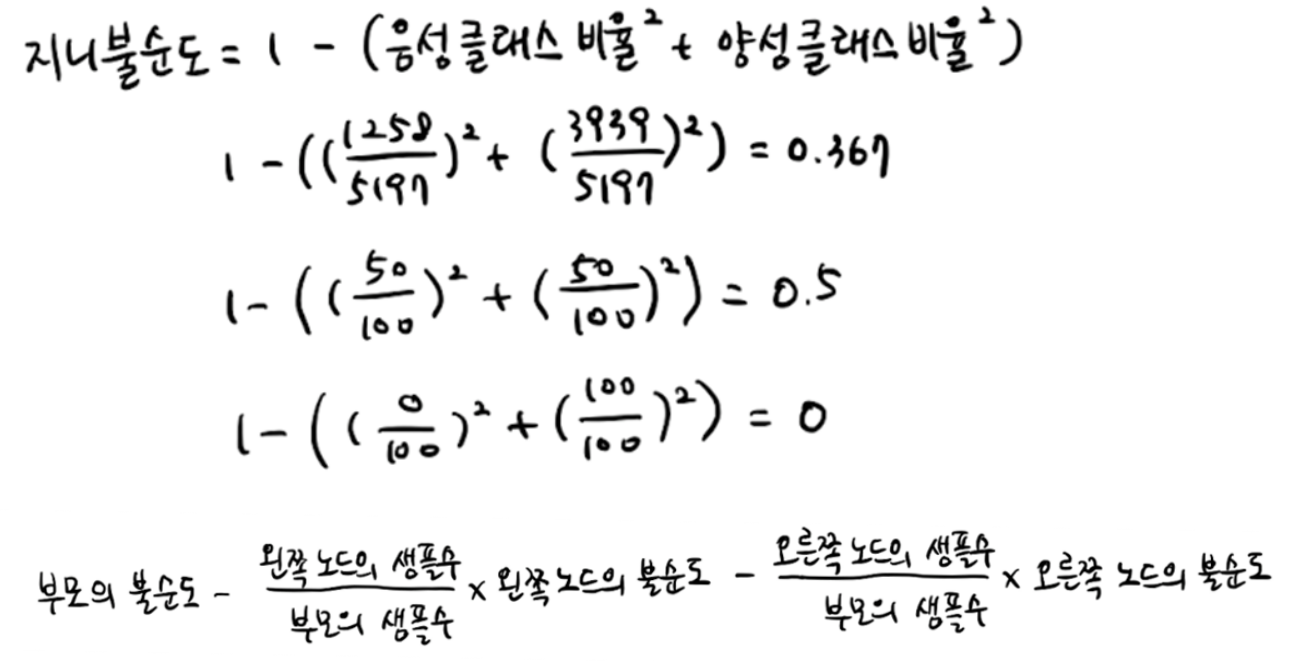

In [24]:
# 가지치기 : 열매를 잘 맺기 위해서 가지치기를 하듯이 결정트리에서도 사용한다.
# 가지치기를 하지 않으면 무장정 끝까지 자라나는 트리를 만듬
# 트리의 깊이(depth)를 지정하면 된다.

# 새로운 객체를 깊이 3으로 만든다.
dt = DecisionTreeClassifier(max_depth=3, random_state=42) # 트리의 깊이 max_depth=3
# 결정트리 모델 생성
# max_depth=3 → 트리가 최대 3단계까지만 분기하도록 제한
# 너무 깊게 자라면서 데이터를 외워버리는(과대적합) 문제를 방지
# random_state=42 → 항상 같은 트리 구조가 나오도록 고정

dt.fit(train_scaled, train_target)
# 훈련 데이터를 이용해 결정 트리 학습 시작
# 가장 좋은 분할 기준(feature + threshold)을 찾아가며 트리 생성

print(dt.score(train_scaled, train_target)) # 84.54%
print(dt.score(test_scaled, test_target))   # 84.15%

0.8454877814123533
0.8415384615384616


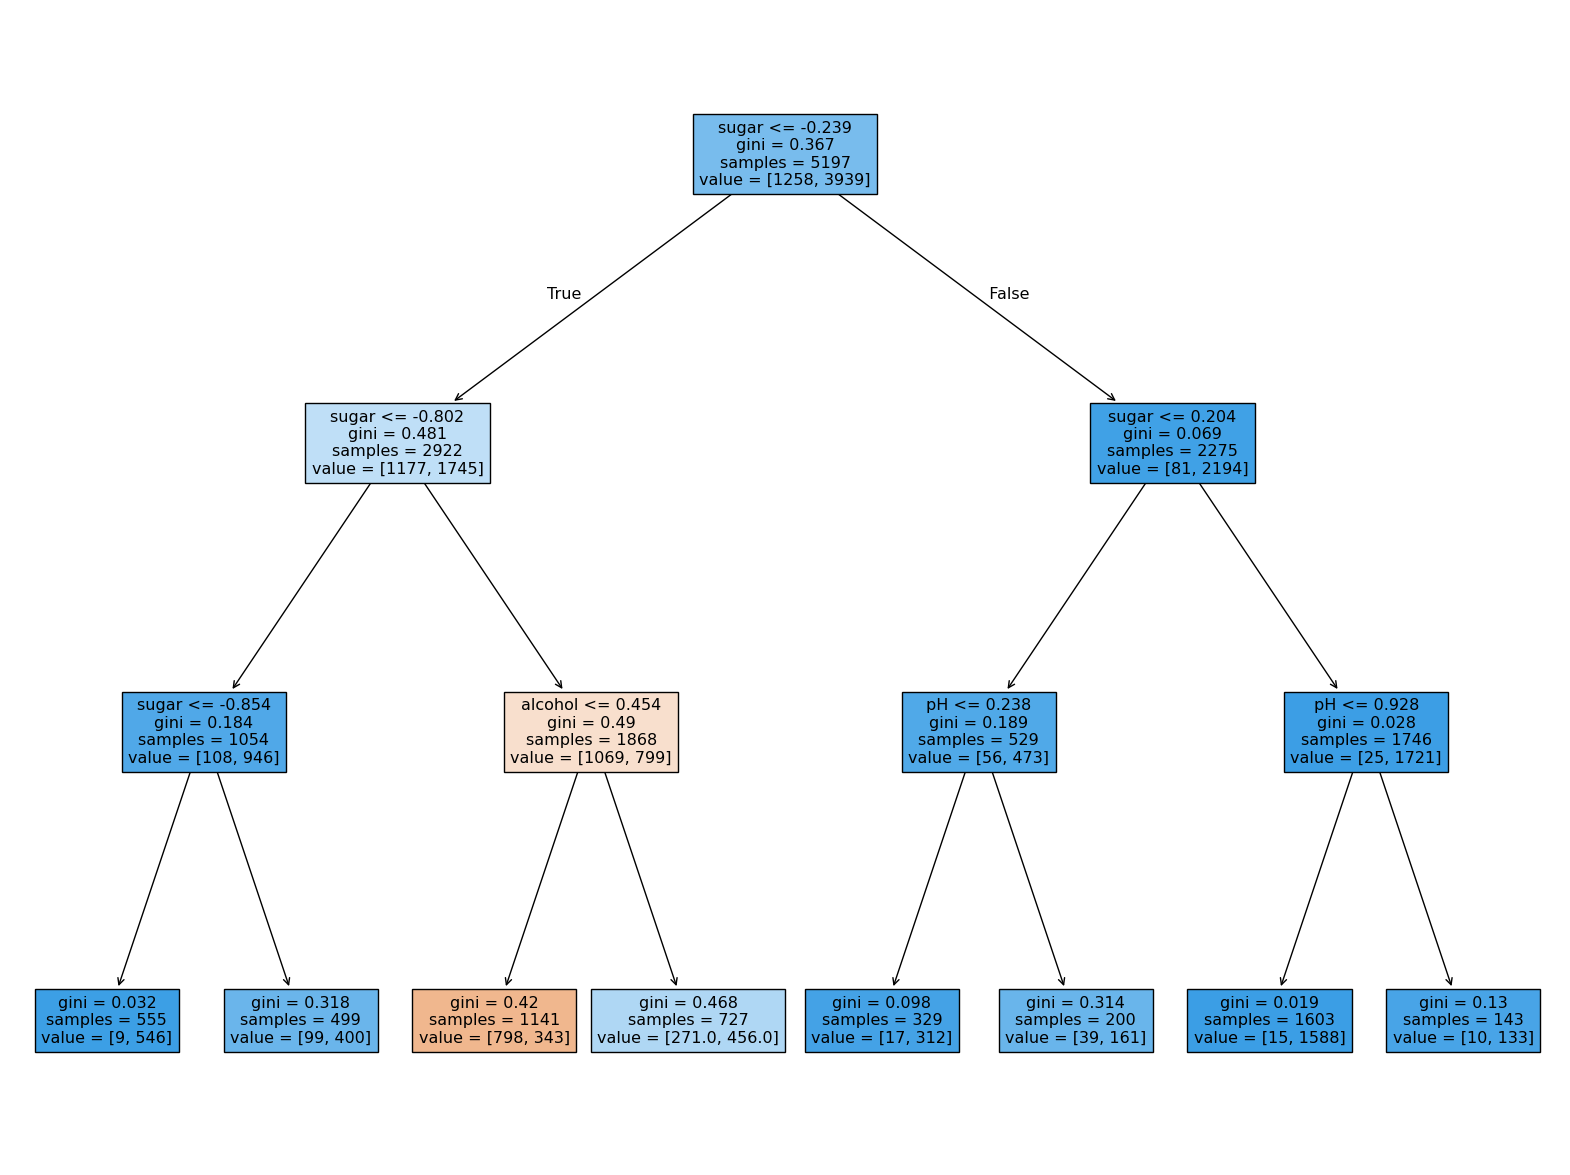

In [25]:
plt.figure(figsize=(20,15))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
plt.show()

In [26]:
# 그래프 분석
# 루트노드(depth=0) 다음 깊에 있는 depth=1 노드는 모두 당도를 기준으로 훈련세트를 나눔
# 하지만 depth=2에서는 맨 왼쪽 노드만 당도를 기준으로 나누고 외쪽에서 두번째 노드는 알콜
# 도수를 기준으로 나눔 오른쪽 두 노드는 pH를 사용합니다.

# 깊이 3에 있는 노드가 최종 노드인 리프 노드이다.
# 왼쪽에서 세번째에 있는 노드만 음성 클래스가 더 많다.
# 이 노드에 도착해야만 레드와인으로 예측함
# 결론 : 당도는 -0.239보다 작고 -0.802보다 커야 함
#        알콜 도수는 0.454보다 작으면 레드 와인이다.

# -0.802라는 음수로된 당도를 상사에게 보고 할수 있나??
# 표준화(표준점수) 전처리를 하지 않고 결정 트리를 사용해보자.(특성값에 스케일은 효과가 없다.)
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
# 깊이 3으로 제한한 결정트리 모델 생성
# max_depth=3 → 과대적합 방지
# random_state=42 → 결과 재현 가능

dt.fit(train_input, train_target)
# 스케일링을 하지 않은 원본 훈련 데이터(train_input)로 학습 시작
# 결정트리는 값의 크기보다 "어디에서 나눌지(기준값)"만 찾기 때문에
# 스케일링 없이도 잘 학습되는 편임

print(dt.score(train_input, train_target))  # 84.52%
print(dt.score(test_input, test_target))    # 84.15% -> 표준화 점수 사용 안함

0.8454877814123533
0.8415384615384616


In [28]:
import numpy as np

sample = np.array([9.5, 1.6, 3.17])
# 새로운 와인 1개의 특징 생성
# 순서 = [alcohol, sugar, pH]
# 즉:
# alcohol = 9.5
# sugar   = 1.6
# pH      = 3.17

sample = sample.reshape(1, -1)
# 머신러닝 모델 입력 형태로 변환
# (특징 3개짜리 1개의 샘플) 형태로 변경

dt.predict(sample)
# 타킷 =0(레드와인), 1(화이트와인)

array([1.])

In [29]:
pred = dt.predict([[9.5,1.6,3.17]])
# 새로운 와인 데이터를 모델에 입력해서 예측 수행
# 입력 형식: [[alcohol, sugar, pH]]
# 결과는 numpy 배열 형태로 반환됨 (예: [0] 또는 [1])

if pred[0] == 0:
    print("Red Wine")
else:
    print("White Wine")

White Wine


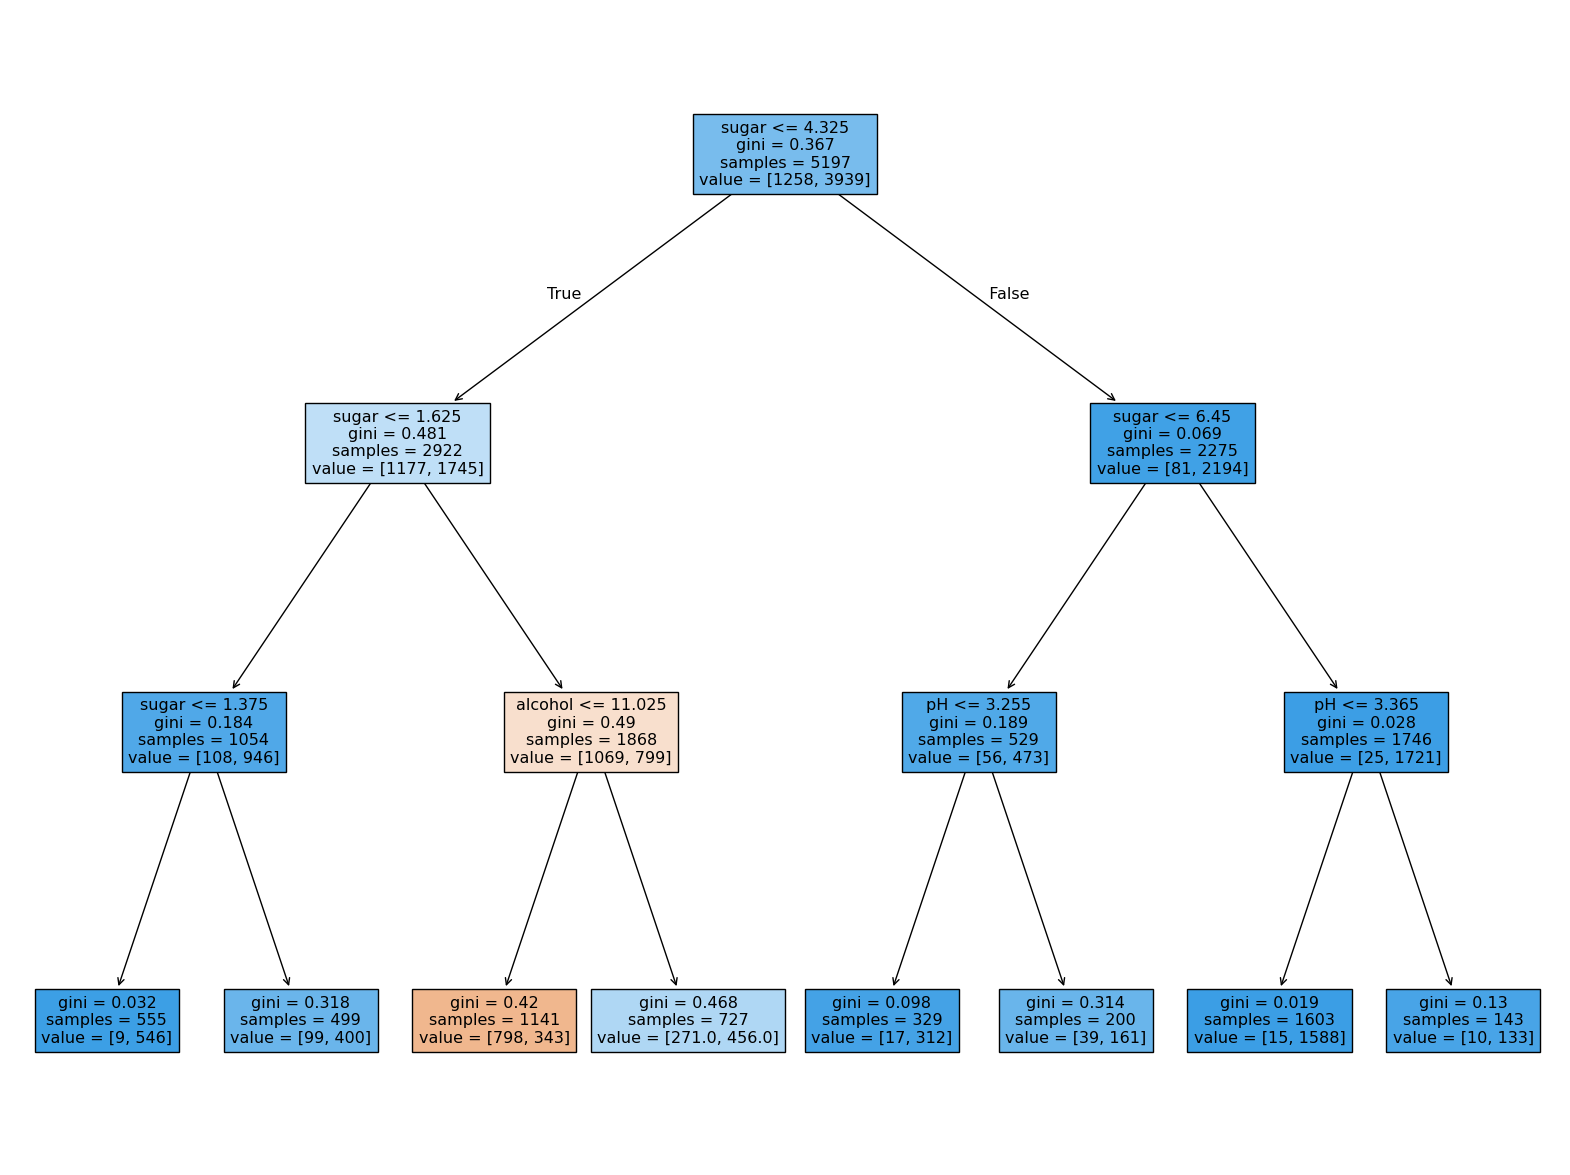

In [30]:
plt.figure(figsize=(20,15))
# 그래프 영역(figure) 생성
# figsize=(가로, 세로) → 큰 트리를 보기 위해 화면을 크게 설정
# 노드가 많을수록 크게 해야 글자가 겹치지 않음

plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
# 학습된 결정트리(dt)를 그림으로 출력

# filled=True
# → 노드를 색으로 채움
#   빨강 계열 : Red Wine 많음
#   파랑 계열 : White Wine 많음
#   색이 진할수록 한쪽 클래스 비율이 높음

# feature_names
# → 각 분기 조건에 실제 컬럼 이름 표시
#   (숫자 인덱스 대신 alcohol, sugar, pH가 보임)

plt.show()

In [ ]:
# 결과 보고서에 넣을 내용
# 당도가 1.625보다 크고 4.325보다 작은 와인 중에
# 알콜 도수가 11.025와 같거나 작은것이 레드와인 으로 판단됨.
# 위 트리에서 주황색 부분이 레드와인으로 판단되고 나머지는 화이트와인이다.!!!

In [31]:
# 결정 트리는 어떤 특성이 가장 유용했는지 나타내는 특성 중요도를 계산해줌
# 결정트리가 학습 과정에서 각 특징(feature)의 중요도를 계산한 값 출력
# 값이 클수록 분류에 많이 사용된 중요한 특징

print(dt.feature_importances_)
# [0.12345626 0.86862934 0.0079144 ] = 다 더하면 1이 나와야 함
#   알콜 도수    당도         ph     -> 순서는 입력값

[0.12345626 0.86862934 0.0079144 ]


In [33]:
#좌우가 균일하지 않은 트리
dt = DecisionTreeClassifier(min_impurity_decrease=0.0005, random_state=42)
# 결정트리 모델 생성
# min_impurity_decrease
# → 노드를 분할했을 때 "불순도(gini)"가 최소 이 값 이상 줄어들어야만 분할 허용
# 즉, 의미 없는 분할은 하지 못하도록 제한하는 장치
# random_state=42
# → 항상 동일한 트리 구조가 만들어지도록 랜덤성 고정
# min_impurity_decrease : 최소 불순도

dt.fit(train_input, train_target)
# 훈련 데이터로 트리 학습 시작
# 분할할 때마다:
# "이 분할이 데이터를 충분히 잘 나누는가?"
# 를 검사하면서 트리 생성

print(dt.score(train_input, train_target))  # 88.74%
print(dt.score(test_input, test_target))    # 86.15%

0.8874350586877044
0.8615384615384616


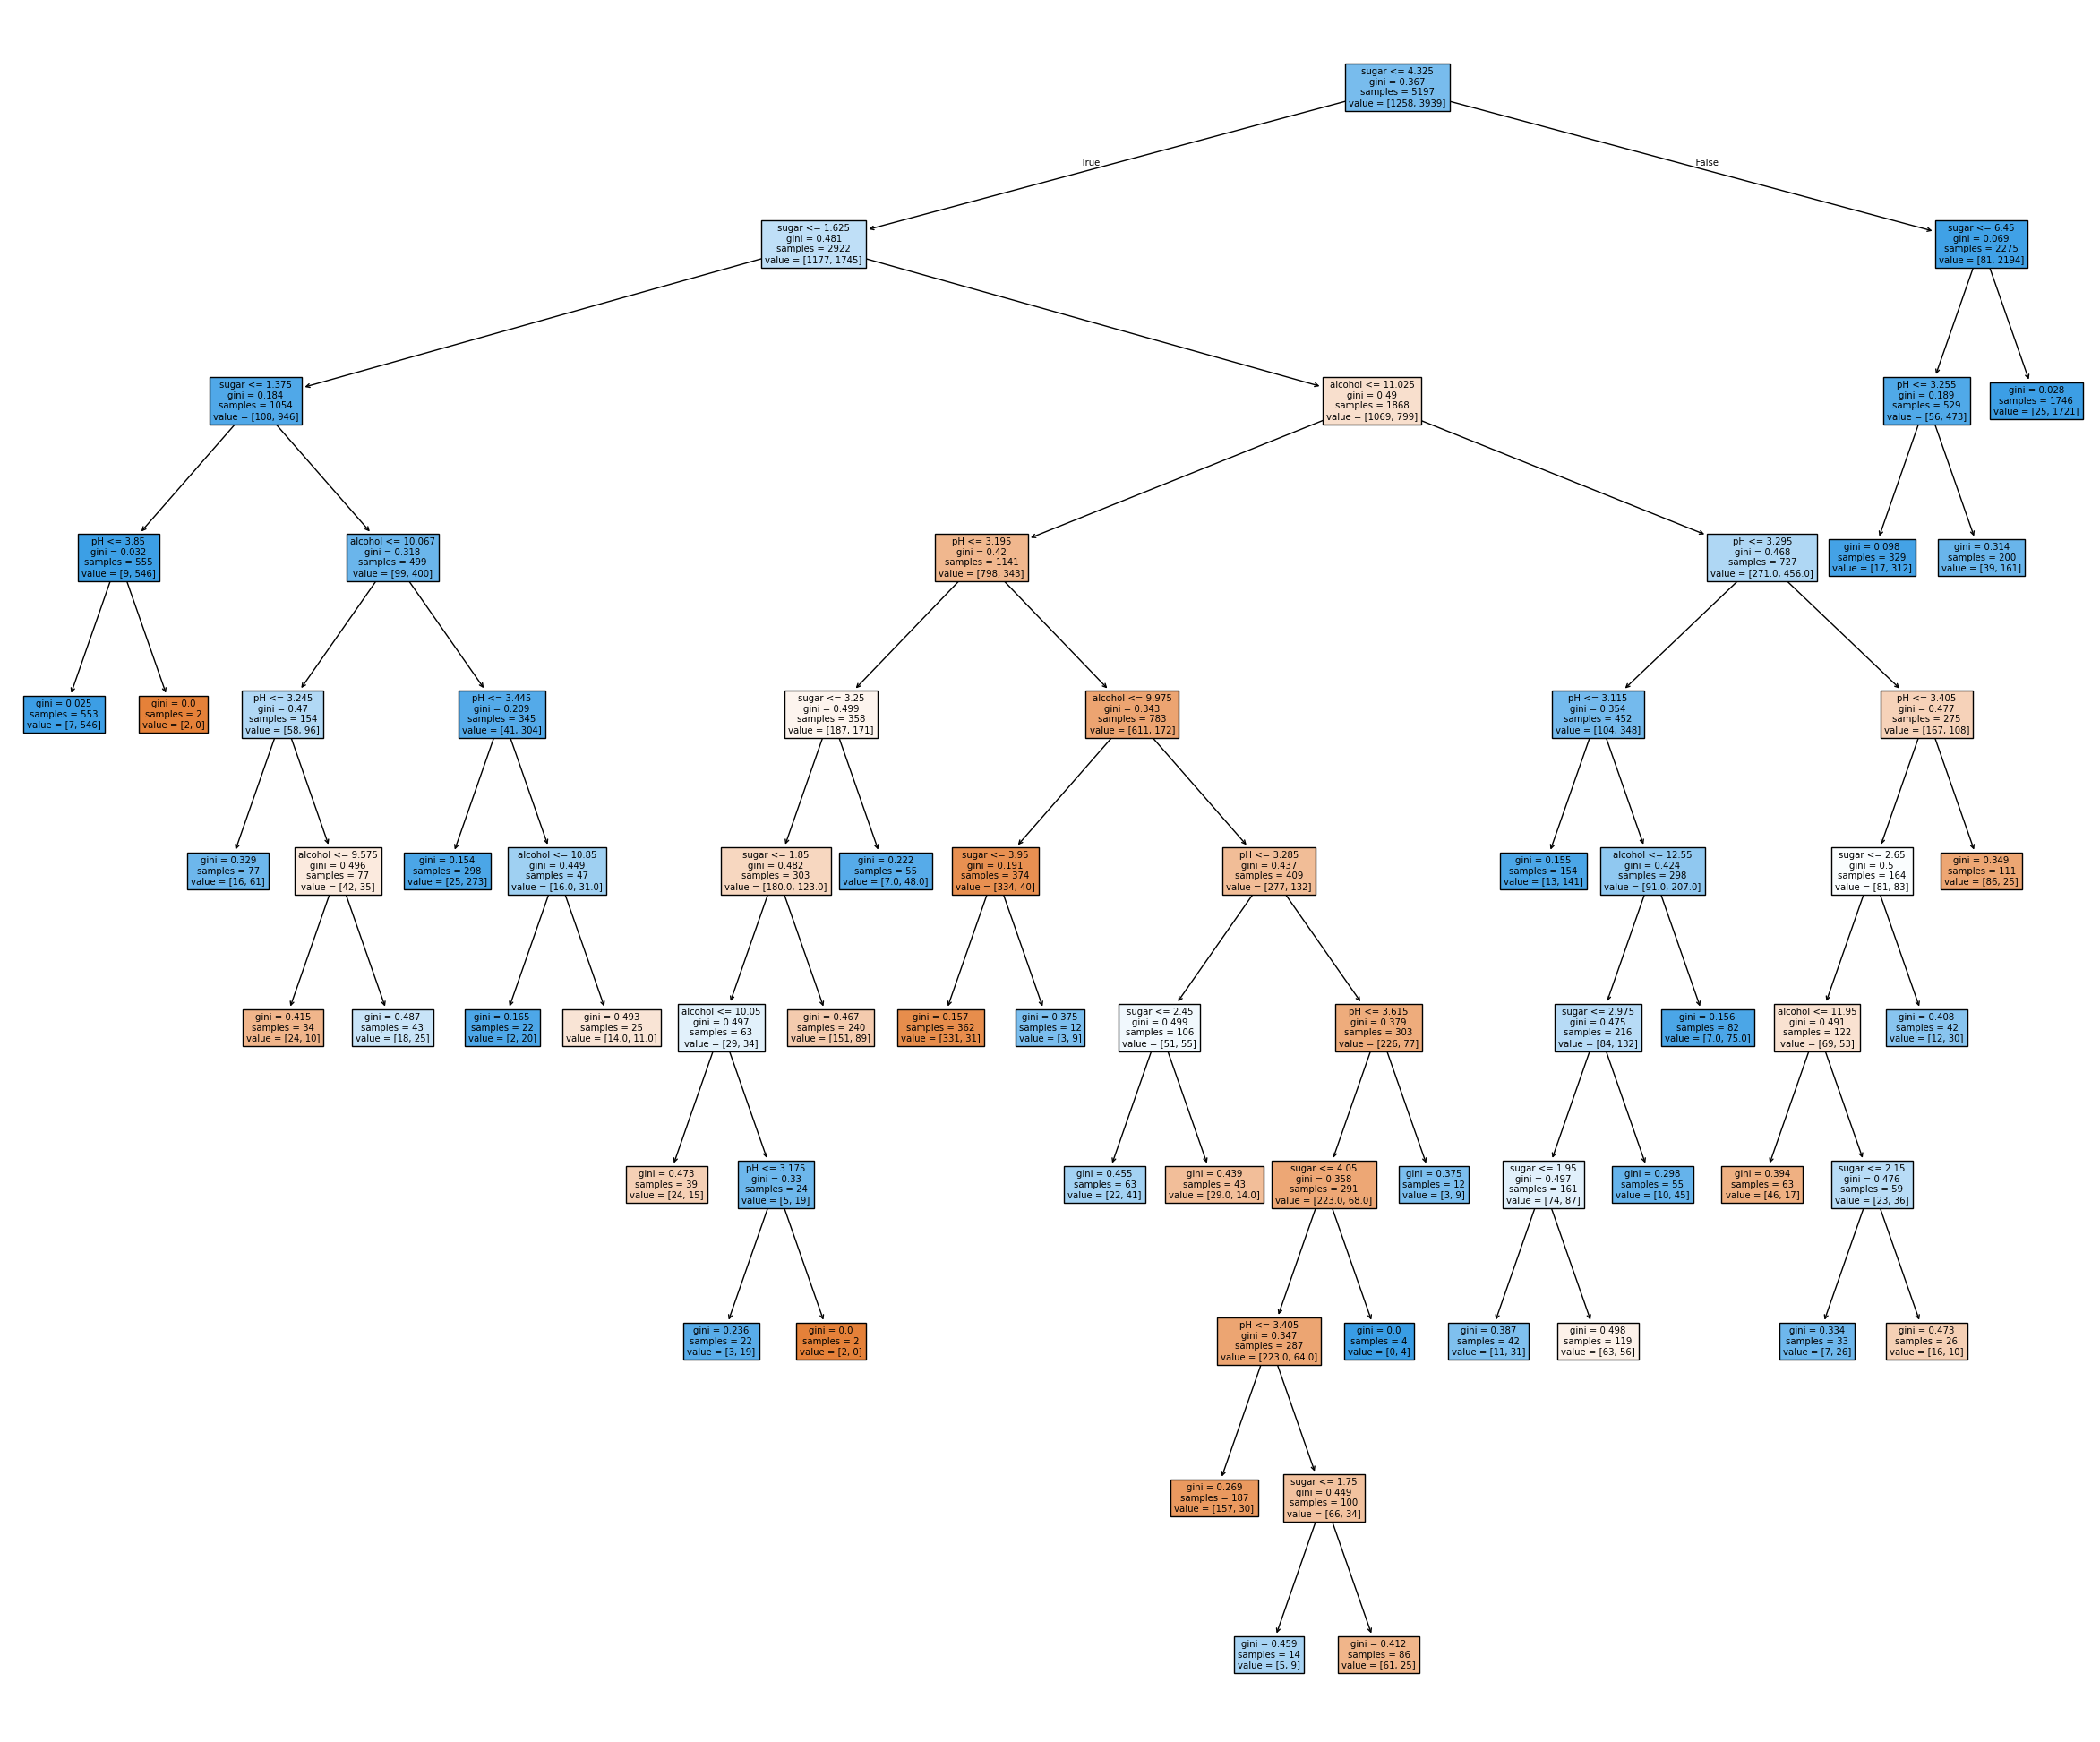

In [34]:
plt.figure(figsize=(30,25))
# 매우 큰 그래프 영역 생성
# 트리 노드가 많기 때문에 크게 확대해서 글자가 겹치지 않도록 설정
# (가로 30, 세로 25 inch → 거의 포스터 크기 느낌)

plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'])
# 학습된 결정트리(dt)를 그림으로 출력

# filled=True
# → 노드를 색으로 채움
#   붉은색 : Red Wine 비율 높음
#   파란색 : White Wine 비율 높음
#   색이 진할수록 한쪽 클래스가 확실함

# feature_names
# → 각 분기 조건에 실제 특성 이름 표시
#   alcohol / sugar / pH 기준으로 어떻게 나뉘는지 확인 가능

plt.show()